N= 623
k= 0 ------------------------------
XX 0.71014494 0.75
XX 0.7536232 0.75
XX 0.75821847 0.7236842
40 8
layer 0  node 0  R= 0.08140077


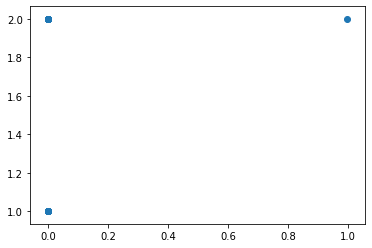

layer 0  node 1  R= 0.61200255


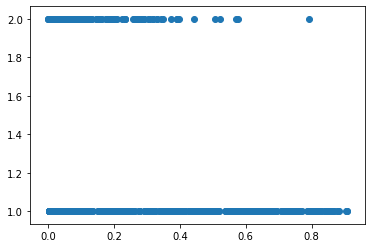

layer 0  node 2  R= 0.72031474


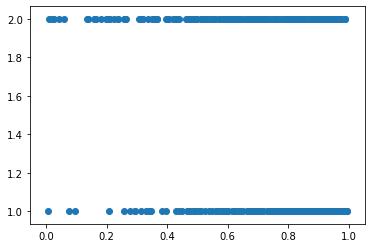

layer 0  node 3  R= 0.07994173


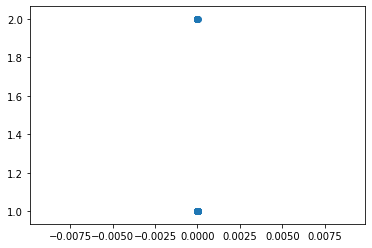

layer 0  node 4  R= 0.15690951


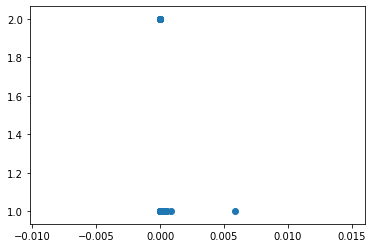

layer 0  node 5  R= 0.22707468


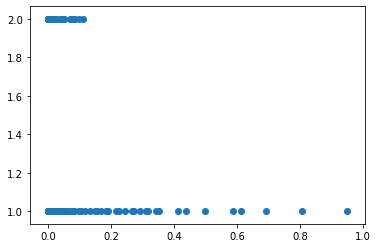

layer 0  node 6  R= 0.06368132


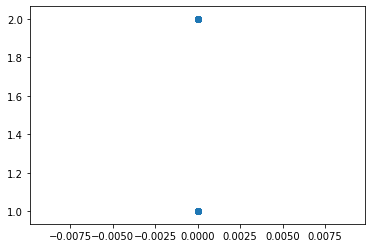

layer 0  node 7  R= 0.20054936


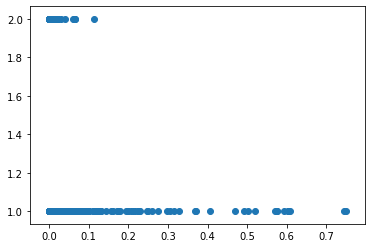

layer 0  node 8  R= 0.65233576


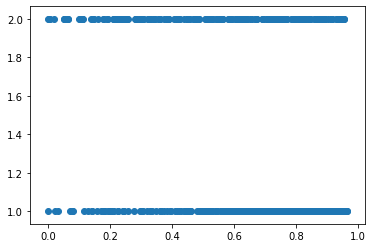

layer 0  node 9  R= 0.20294753


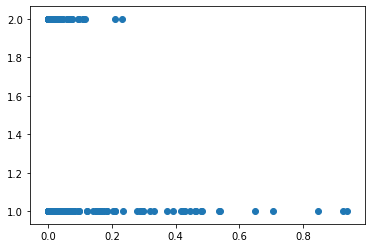

layer 0  node 10  R= 0.29647642


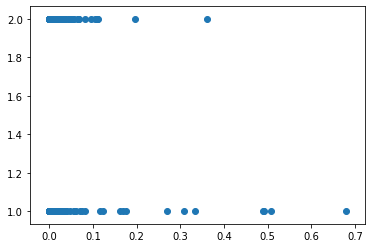

layer 0  node 11  R= 0.07997645


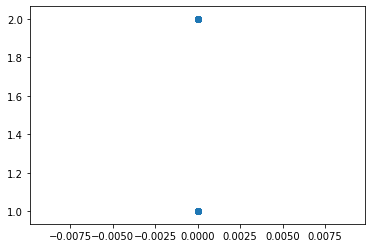

layer 0  node 12  R= 0.54482853


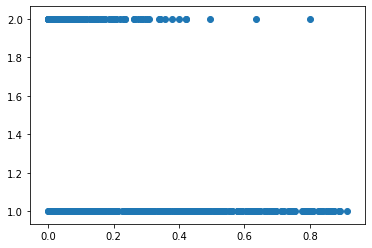

layer 0  node 13  R= 0.10446417


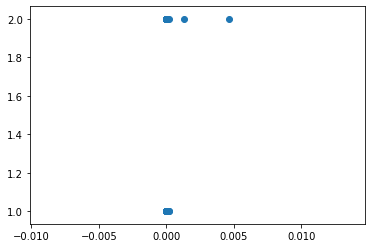

layer 0  node 14  R= 0.22841266


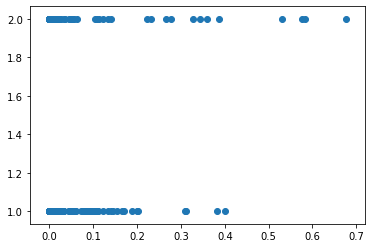

layer 0  node 15  R= 0.22747247


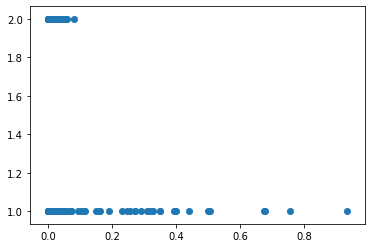

layer 0  node 16  R= 0.7110479


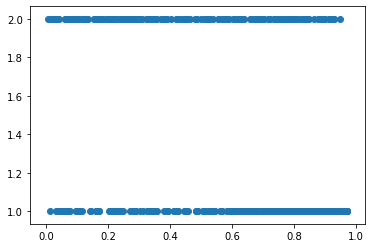

layer 0  node 17  R= 0.16750447


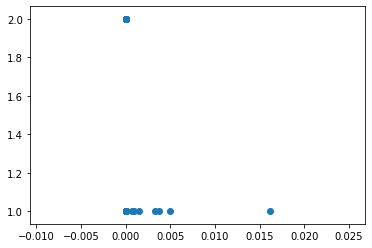

layer 0  node 18  R= 0.76141775


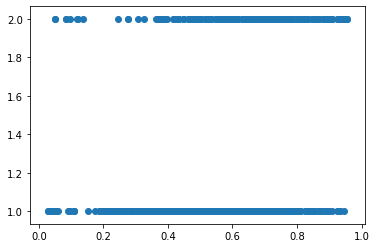

layer 0  node 19  R= 0.4810405


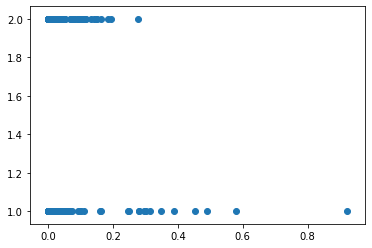

layer 0  node 20  R= 0.53249687


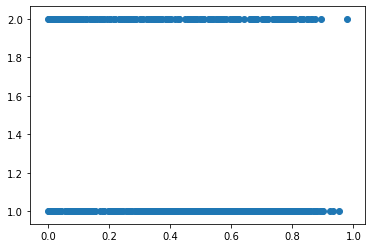

layer 0  node 21  R= 0.26774964


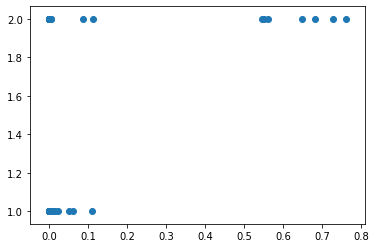

layer 0  node 22  R= 0.76024806


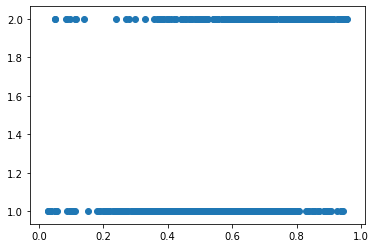

layer 0  node 23  R= 0.4155304


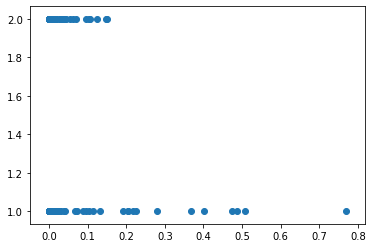

layer 0  node 24  R= 0.31068957


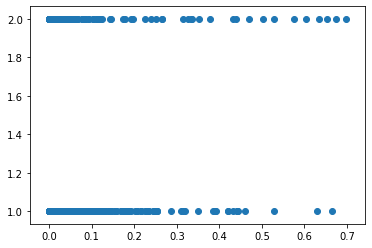

layer 0  node 25  R= 0.48996255


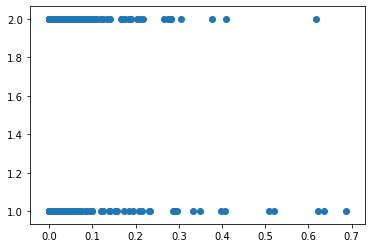

layer 0  node 26  R= 0.42384103


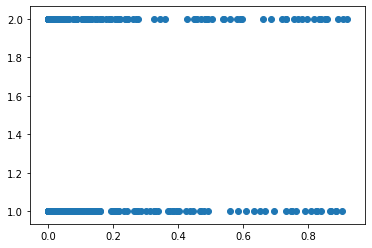

layer 0  node 27  R= 0.6101605


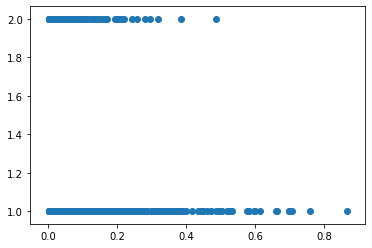

layer 0  node 28  R= 0.07488853


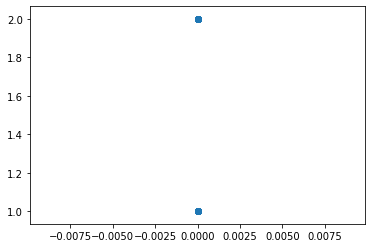

layer 0  node 29  R= 0.41042948


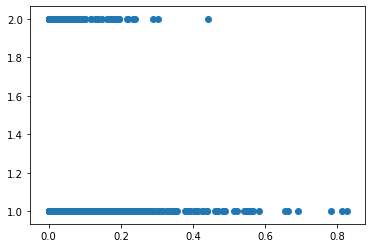

layer 0  node 30  R= 0.52036


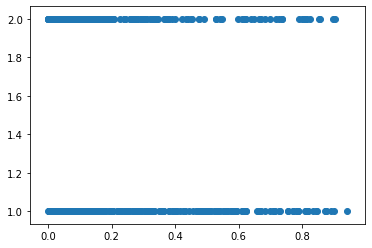

layer 0  node 31  R= 0.24192566


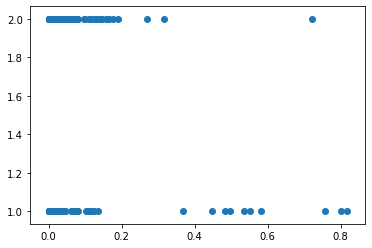

layer 0  node 32  R= 0.36266813


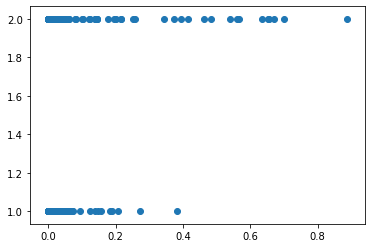

layer 0  node 33  R= 0.076755255


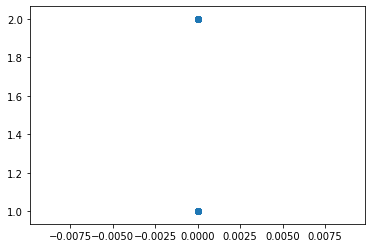

layer 0  node 34  R= 0.3526486


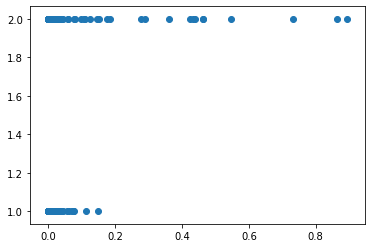

layer 0  node 35  R= 0.3571744


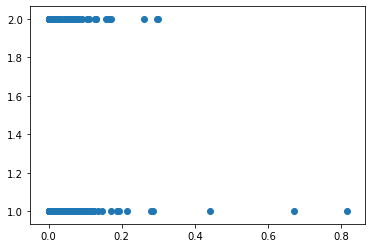

layer 0  node 36  R= 0.45622298


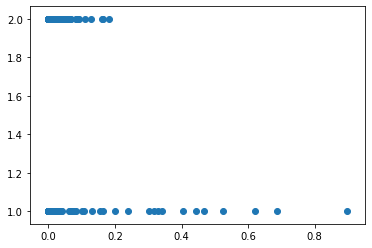

layer 0  node 37  R= 0.23424117


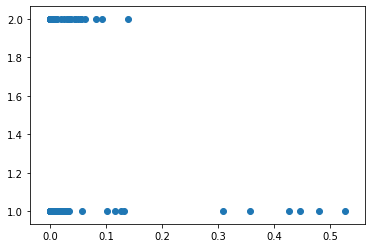

layer 0  node 38  R= 0.3991809


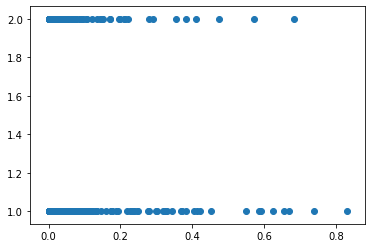

layer 0  node 39  R= 0.24492654


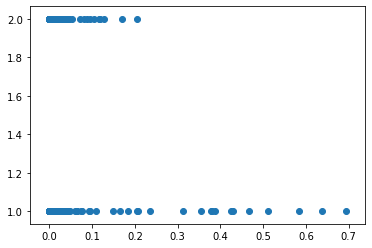

accuracy: 0.7236842
k= 1 ------------------------------
XX 0.79710144 0.7631579
XX 0.8150449 0.7236842
XX 0.8200778 0.7236842
XX 0.8218104 0.7236842
accuracy: 0.7236842
k= 2 ------------------------------
accuracy: 0.7236842
k= 3 ------------------------------
accuracy: 0.7236842
k= 4 ------------------------------
accuracy: 0.7236842
k= 5 ------------------------------
accuracy: 0.7236842
k= 6 ------------------------------
accuracy: 0.7236842
k= 7 ------------------------------
accuracy: 0.7236842
k= 8 ------------------------------
40 8
layer 0  node 0  R= 0.14995436


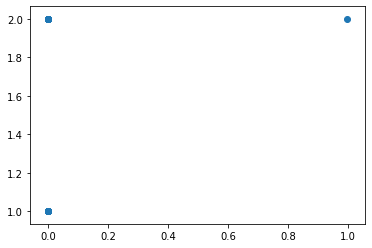

layer 0  node 1  R= 0.24290317


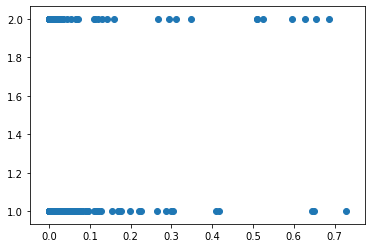

layer 0  node 2  R= 0.61895174


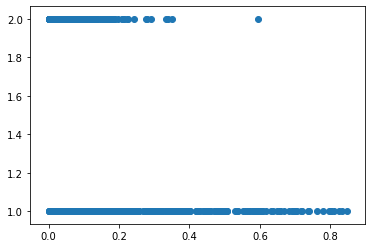

layer 0  node 3  R= 0.08720248


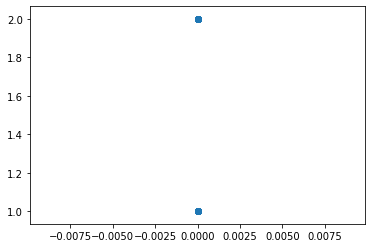

layer 0  node 4  R= 0.33344936


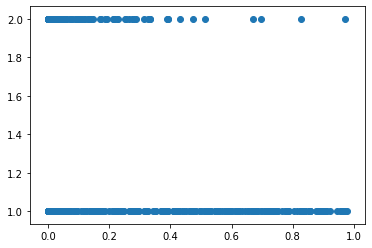

layer 0  node 5  R= -0.03505387


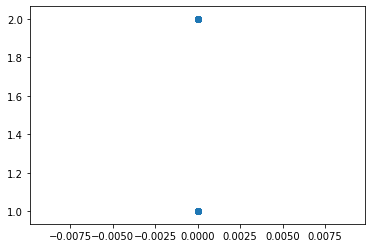

layer 0  node 6  R= 0.38787815


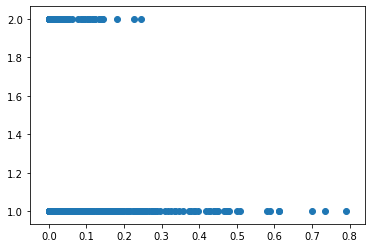

layer 0  node 7  R= 0.2929408


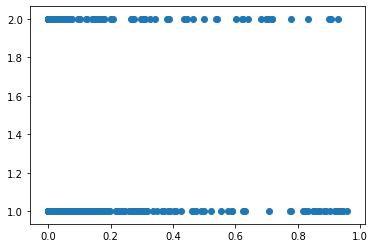

layer 0  node 8  R= 0.19731806


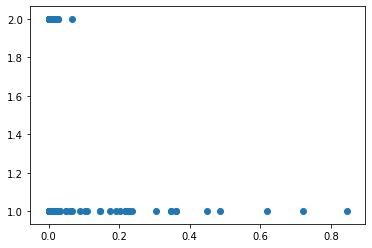

layer 0  node 9  R= 0.6521742


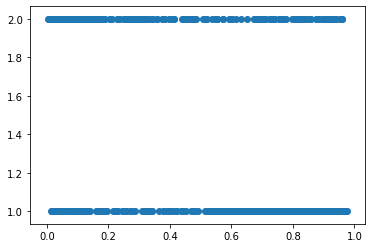

layer 0  node 10  R= 0.24542841


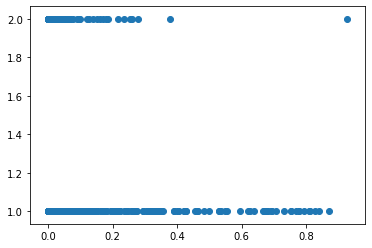

layer 0  node 11  R= 0.6507986


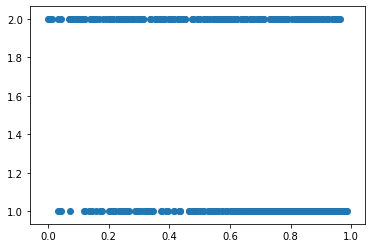

layer 0  node 12  R= 0.2573123


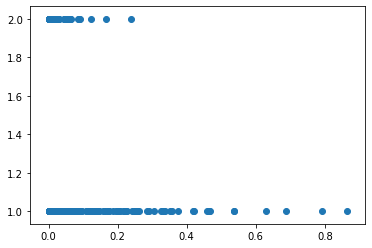

layer 0  node 13  R= 0.47916123


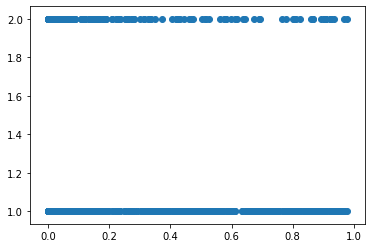

layer 0  node 14  R= 0.48287138


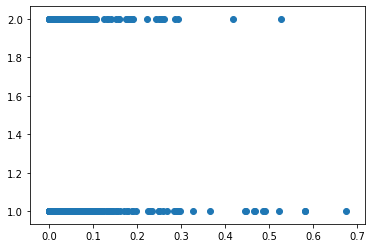

layer 0  node 15  R= 0.08472394


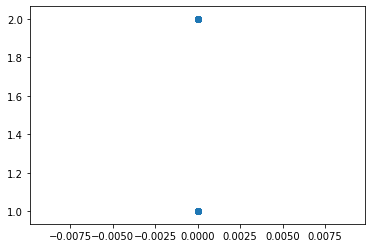

layer 0  node 16  R= 0.23426719


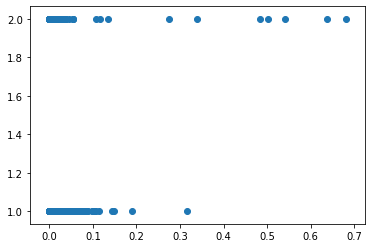

layer 0  node 17  R= 0.48107305


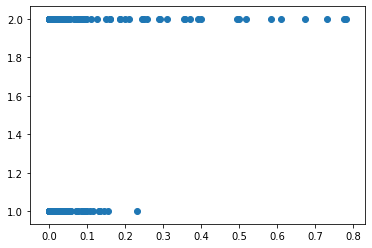

layer 0  node 18  R= 0.3722431


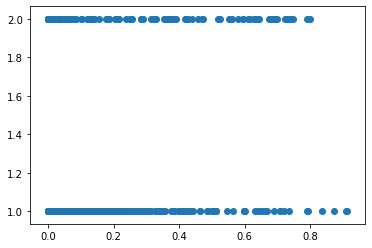

layer 0  node 19  R= 0.3938797


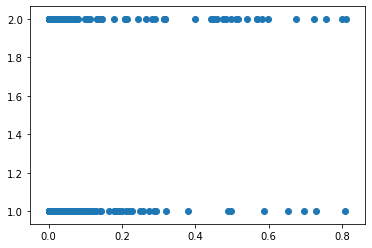

layer 0  node 20  R= 0.22324848


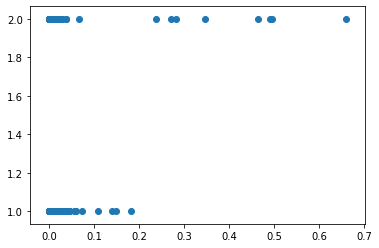

layer 0  node 21  R= 0.506253


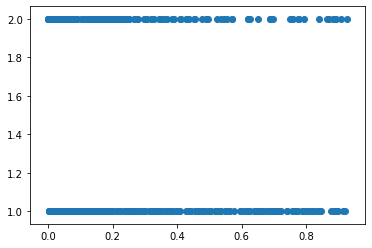

layer 0  node 22  R= 0.7891189


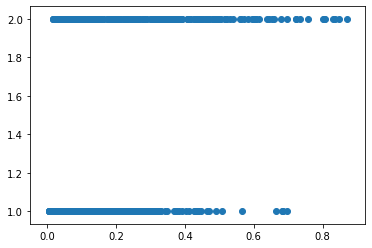

layer 0  node 23  R= 0.4729539


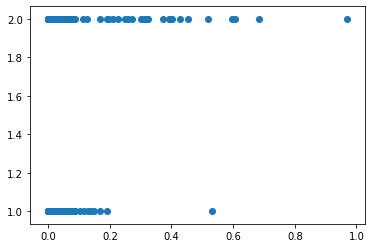

layer 0  node 24  R= 0.101685636


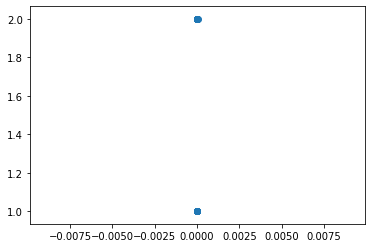

layer 0  node 25  R= 0.35122362


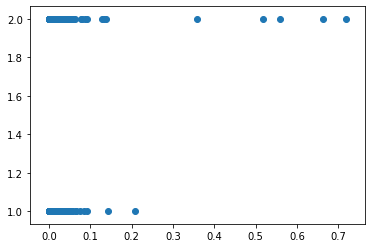

layer 0  node 26  R= 0.43201393


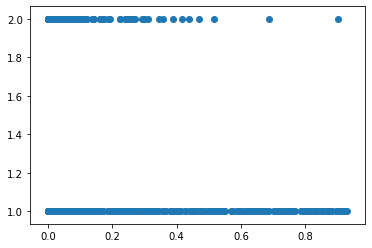

layer 0  node 27  R= 0.40949813


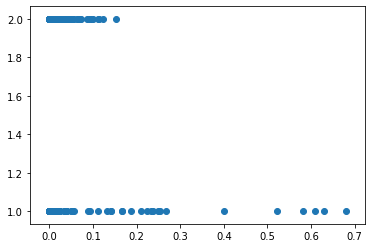

layer 0  node 28  R= 0.3443452


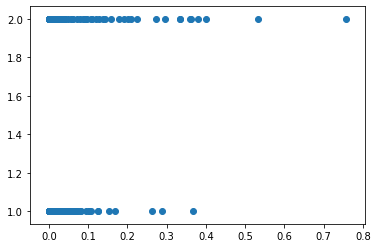

layer 0  node 29  R= 0.08745668


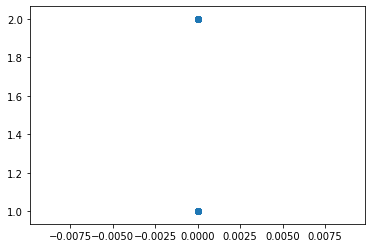

layer 0  node 30  R= 0.79211897


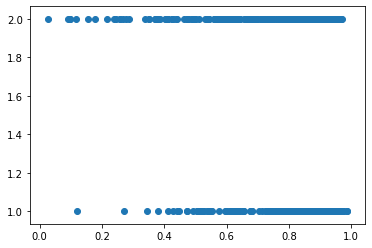

layer 0  node 31  R= 0.22194639


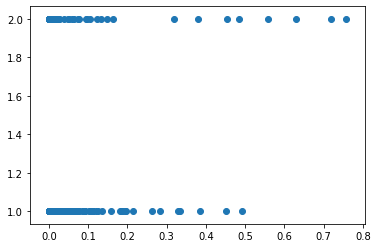

layer 0  node 32  R= 0.6063572


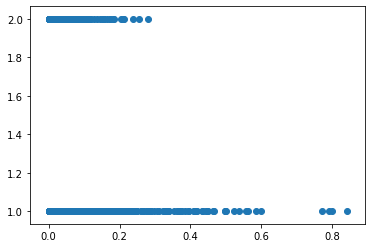

layer 0  node 33  R= 0.6851162


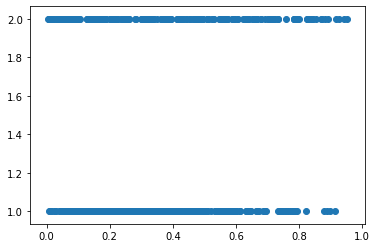

layer 0  node 34  R= 0.3220714


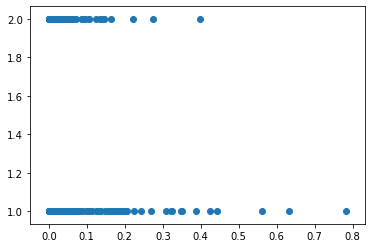

layer 0  node 35  R= 0.35256436


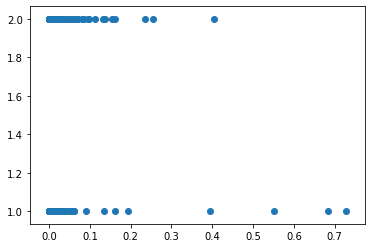

layer 0  node 36  R= 0.2810285


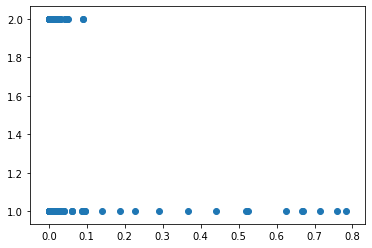

layer 0  node 37  R= 0.5262932


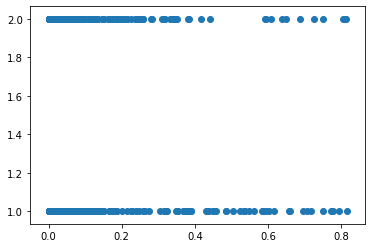

layer 0  node 38  R= 0.2080941


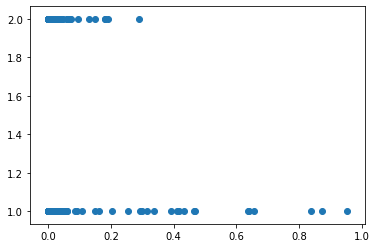

layer 0  node 39  R= 0.8000644


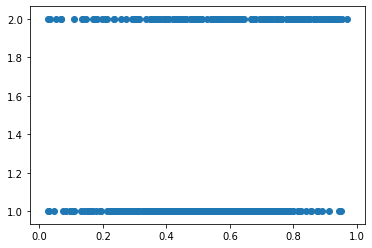

accuracy: 0.7236842
k= 9 ------------------------------
accuracy: 0.7236842


In [48]:
# hybrid model DLS

# P 05
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.activations import relu
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_blobs
import numpy as np
import random 


#tf.enable_eager_execution()


class LSLayer(tf.keras.layers.Layer):
    
    def __init__(self,  num_outputs_s, num_outputs_r, num_outputs_l, indata,  activation=sigmoid, wstd = 0.3, bstd = 0.5):
        super(LSLayer, self).__init__()
        self.num_outputs_l = num_outputs_l
        self.num_outputs_s = num_outputs_s 
        self.num_outputs_r = num_outputs_r
        self.num_outputs = num_outputs_l + num_outputs_s + num_outputs_r
        self.activation = activation
        self.wstd = wstd
        self.bstd = bstd
        self.traindata = indata
        
    def build(self, input_shape):  
        self.num_inputs = input_shape[-1]
        self.kernel = self.add_weight("kernel",
                                      shape=(int(input_shape[-1]),
                                             self.num_outputs), 
                                      initializer=tf.keras.initializers.RandomNormal(stddev=self.wstd),
                                     trainable=True)

        self.bias = self.add_weight("bias",
                                      shape=[self.num_outputs],
                                    initializer=tf.keras.initializers.RandomNormal(stddev=self.bstd),
                                   trainable=True)
            
        #print ( "set_circles ---------------------------")
        
        M = self.num_outputs_s + self.num_outputs_r
        x_train =  self.traindata[0]
        y_train =  self.traindata[1]
        N = x_train.shape[0]   
        D = x_train.shape[1]   
        C = min (M*10,int(0.1*N))
        #print ("C",C,"M",M)
        
        cls = KMeans(n_clusters=C).fit(x_train)
        
        centers = cls.cluster_centers_
        #print ("centers", centers.shape)
        #print (centers)
        labels = cls.labels_

        cvals = []
        for c in range(C):
            db1 = 0
            db2 = 0
            for i in range(N):
                if labels[i] == c:
                    if y_train[i][0] == 1:
                        db1 += 1
                    else:
                        db2 += 1
            try:
                h = -math.log(db1/(db1+db2))*db1/(db1+db2) - math.log(db2/(db1+db2))*db2/(db1+db2) 
            except:
                h = 0
            #print ("class:", c,db1 + db2, db1, db2,h)
            cvals.append((c,(db1+db2)* (1 - h)))

        #print (cvals)
        cvals.sort(key = lambda x: x[1] )
        #print (cvals)

        winc = []
        #print (M)
        for i in range(M):
            cw = cvals[-i][0]
            d0 = 0
            for j in range(N):
                if labels[j] == cw:
                    d = math.sqrt(sum([ (centers[cw][k] - x_train[j][k])**2 for k in range(D) ]  ))
                    if d > d0:
                        d0 = d
            winc.append((cw, centers[cw], d0 ) )

        #for i in range(len(winc)):
        #    print (i,  ':', winc[i])
        #print ("end -------------------------------")

        xu = self.get_weights()

        #print (xu[0].shape, xu[1].shape)
        
        for c in range(D):
            for m in range(M):
                xu[0][c,m] = winc[m][1][c]
        
        
        for m in range(M):
            xu[1][m] = winc[m][2]
            
        #print (xu[0])
        #print (xu[1])
            
        self.set_weights(xu )
        #print ("end ==============================")
        
    
    # F2 method LS layer
    def call(self, input):
        
        #print ("CALL :", input.numpy())
        isp = input.shape
        In1 = tf.transpose(input)
        kernel_S, kernel_L  = tf.split(self.kernel,[ self.num_outputs_s + self.num_outputs_r, self.num_outputs_l ], axis = 1 )
        bias_S, bias_L  = tf.split(self.bias,[ self.num_outputs_s +  self.num_outputs_r, self.num_outputs_l ], axis = 0 )
        
        # case spherical
        
        s_shape  = self.num_outputs_s + self.num_outputs_r
        In2 = tf.stack([In1] * s_shape)
        InD = tf.transpose(In2)
        WD = tf.stack([kernel_S] * isp[0])
        ddd = WD - InD
        dd0 = tf.math.multiply(ddd, ddd)
        dd1 = tf.math.reduce_sum(dd0, axis =1)
        dd2 = tf.cast(dd1,tf.double)
        dd3 = tf.sqrt(dd2)
        d_r = tf.cast(dd3,tf.float32)
        d_R = tf.abs(bias_S)
        d_rR = tf.math.divide_no_nan(d_r,d_R)
        d_x0 = tf.ones(d_rR.shape) - d_rR
        result_S = tf.math.scalar_mul(6,d_x0)
        result_S = sigmoid(result_S)
        #print ("OUT")
        #print(result_S.numpy())
        
        # case linear

        d_1 = tf.stack([bias_L] * isp[0])
        result_L = tf.matmul(input, kernel_L) + d_1 
        result_L = relu(result_L)

        #case empty, merge
        
        '''
        #print (self.num_outputs_r)
        if self.num_outputs_r > 0:
            r_S, _ = tf.split (result_S,[self.num_outputs_s, self.num_outputs_r],axis=1 )
            r_1 = np.zeros((result_S.shape[0],self.num_outputs_r))
            result_R = tf.cast(tf.constant(r_1),tf.float32)
            result = tf.concat([r_S, result_R, result_L],axis=1)            
            #print (self.num_outputs_s, self.num_outputs_r)
            #print ("result_S", result_S)
            #print ("result_L", result_L)
            #print ("result", result)
        else:
            result = tf.concat([result_S, result_L],axis=1)        
        '''
        
        result = tf.concat([result_S, result_L],axis=1)        
        
        return result
    
        

class NN_Model(Model):
    
    def __init__(self,c,hs,hr,hl,indata):
        super(NN_Model, self).__init__()
        self.d1 = LSLayer(hs,hr,hl,indata)
        self.d2 = Dense(c)
        
    def call(self, x):
        x = self.d1(x)
        #print ("call benn:",x, tf.math.reduce_sum(x))
        return self.d2(x)
        
        


#@tf.function
def train_step(datas, labels,modelk,loss_objectk,optimizerk,train_lossk,train_accuracyk):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = modelk(datas, training=True)
        loss = loss_objectk(labels, predictions)
    gradients = tape.gradient(loss, modelk.trainable_variables)
    optimizerk.apply_gradients(zip(gradients, modelk.trainable_variables))

    train_lossk(loss)
    train_accuracyk(labels, predictions)

#@tf.function
def test_step(datas, labels,modelk,loss_objectk,test_lossk,test_accuracyk):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    
    predictions = modelk(datas, training=False)
    t_loss = loss_objectk(labels, predictions)

    test_lossk(t_loss)
    test_accuracyk(labels, predictions)
        

    
def view_NN (model, train_ds,optimizer):
    cnt = 0
    L = 0
    xu = model.layers[L].get_weights()
    C = xu[0].shape[1]
    M = xu[0].shape[0]
    print (C,M)
    for c in range(C):
        cnt = 0
        outs = []
        for datas, labels in train_ds:
            dA = datas.numpy()
            dL = labels.numpy()
            for i in range(dA.shape[0]):
                cnt += 1
                cat = np.argmax(dL[i]) + 1
                tA1 = tf.constant(dA[i])
                tA = tf.reshape(tA1,[1,dA.shape[1]])
                if L == 1:
                    to1 = model.d1 (tA)
                    to2 = model.d2 (to1)
                else:
                    to2 =  model.d1 (tA)
                #print (tA.numpy())
                #print (to2.numpy())
                outs.append((to2[0][c].numpy(), cat))
        print ("layer", L, " node",  c, " R=",xu[1][c])
        X = [x[0] for x in outs]
        Y = [x[1] for x in outs]
        plt.scatter(X,Y)
        #print (outs)
        plt.show()
    
    
    
def analyse_NN (model, train_ds,optimizer):
    
    #print ("===============================================")
    cnt = 0
    xu = model.d2.get_weights()
    C = xu[0].shape[1]
    M = xu[0].shape[0]
    Nfitness = [0 for _ in range(M)]
    for datas, labels in train_ds:
        dA = datas.numpy()
        dL = labels.numpy()
        for i in range(dA.shape[0]):
            cnt += 1
            #print ("sample ", cnt, "..................")
            tA1 = tf.constant(dA[i])
            tA = tf.reshape(tA1,[1,dA.shape[1]])
            #predictions = model(tA, training=False)
            to1 = model.d1 (tA)
            to2 = model.d2 (to1)
            #print ("output:",to2.numpy()[0],"labels", dL[i])
            #print (xu[0].shape)
            for j in range(M):
                vl = []
                for c in range(C):
                    xw = xu[0][:,c]
                    xo1 = to1.numpy()[0]
                    val = xo1[j]*xw[j] +  tf.constant(xu[1][c]).numpy() / M 
                    vl.append(val)
                if vl.index(max(vl)) == list(dL[i]).index(max(dL[i])):
                    val = 1
                else:
                    val = 0            
                Nfitness[j] += val
    
    
    
    #for j in range(M):
    #    mode = "S"
    #    if j >= model.d1.num_outputs_s + model.d1.num_outputs_r:
    #        mode = "L"
    #    print (j, mode, 'val:', Nfitness[j])                
    print ('                   ', sum(Nfitness),min(Nfitness),max(Nfitness))                               
            
    #print ("===============================================")

    
def update_NN_model (model, train_ds,optimizer):

    rdb = 0
    odb = 0
    #N = min(5, model.d1.num_outputs_r)   # number of new SSN nodes
    N = model.d1.num_outputs_r   # number of new SSN nodes
    
    if N <= 0:
        return
    
    # k-means
    
    baditems = []
    for datas, labels in train_ds:
        predictions = model(datas, training=False)
        for i in range(datas.shape[0]):
            #print (datas.numpy()[i], predictions.numpy()[i], np.argmax(predictions.numpy()[i]), labels.numpy()[i],np.argmax(labels.numpy()[i]))
            if np.argmax(predictions.numpy()[i]) != np.argmax(labels.numpy()[i]):
                rdb = rdb + 1
                baditems.append(datas.numpy()[i])
            odb = odb + 1        
    #print ("pontossag:",(odb-rdb)/odb, len(baditems))
    N = min(N, len(baditems))
    if N == 0:
        return
    inds = random.sample(range(len(baditems)), N)
    
    print ("update layer")
    #print (baditems)
    centers = KMeans(n_clusters=N).fit(baditems).cluster_centers_
    #print ("centers:")
    #print (centers)
    neww = np.zeros((model.d1.num_inputs,N))
    for i in range(N):
        for j in range(model.d1.num_inputs):
            neww[j,i] = centers[i][j]
    #print ("neww")
    #print (neww)
            
    xu = model.d1.get_weights()
        
    idx = random.sample(range(model.d1.num_outputs_s + model.d1.num_outputs_r),N)
    for j1 in range(N):
        j = idx[j1]
        for i in range(xu[0].shape[0]):
            xu[0][i][j] = neww[i,j1]
           
    for j1 in range(N):
        j = idx[j1]
        r = 0
        for i in range(xu[0].shape[0]):
            r += (xu[0][i][j]-0.5)**2
        r = 0.1*math.sqrt(r)
        xu[1][j] = r
            
            
    model.d1.set_weights(xu )
    
    #model.d1.num_outputs_s = model.d1.num_outputs_s + N
    #model.d1.num_outputs_r = model.d1.num_outputs_r - N

    #optimizer = tf.keras.optimizers.Adam
    #for var in optimizer.variables():
    #    var.assign(tf.zeros_like(var))
    

K = 10

# (x_train,y_train,x_test,y_test) = gen_data_array_cv(K)

M = x_train[0].shape[1]
C = y_train[0].shape[1]

EPOCHS = 80
Eupd = [20]

H = M * 5
HS = 5*M
HR = 0
HL = 0
B = 32

model = []
loss_object =  []
optimizer = []
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
val_loss = []
val_accuracy = []
train_ds = []
val_ds = []
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(B)



best_v = 0
best_t = 0

print ("N=", x_train[0].shape[0])

for k in range(K):
    print ("k=",k, "------------------------------")
    # Create an instance of the model
    model.append( NN_Model(C,HS,HR,HL,(x_train[k], y_train[k])))
    #model.append( NN_Model(H,C,0,0))

    loss_object.append(tf.keras.losses.CategoricalCrossentropy(from_logits=True))
    #loss_object = tf.keras.losses.CategoricalCrossentropy()

    #optimizer.append(tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,))
    optimizer.append(tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07,))
    train_loss.append(tf.keras.metrics.Mean(name='train_loss'))
    train_accuracy.append(tf.keras.metrics.CategoricalAccuracy(name='train_accuracy'))

    test_loss.append(tf.keras.metrics.Mean(name='test_loss'))
    test_accuracy.append(tf.keras.metrics.CategoricalAccuracy(name='test_accuracy'))
    
    val_loss.append(tf.keras.metrics.Mean(name='val_loss'))
    val_accuracy.append(tf.keras.metrics.CategoricalAccuracy(name='val_accuracy'))
    

    #print (x_train[:2])
    train_ds.append( tf.data.Dataset.from_tensor_slices(
        (x_train[k], y_train[k])).batch(B))
    val_ds.append( tf.data.Dataset.from_tensor_slices(
        (x_val[k], y_val[k])).batch(B))
    #print (train_ds)


    ##set_circles(model[k],x_train[k], y_train[k], HS+HR)


    X = []
    Y = []
    for epoch in range(EPOCHS):
      # Reset the metrics at the start of the next epoch

        train_loss[k].reset_states()
        train_accuracy[k].reset_states()
        test_loss[k].reset_states()
        test_accuracy[k].reset_states()
        

        for datas, labels in train_ds[k]:
            train_step(datas, labels,model[k],loss_object[k],optimizer[k],train_loss[k],train_accuracy[k])


        for test_datas, test_labels in test_ds:
            #tpredictions = model[k](test_datas, training=False)
            test_step(test_datas, test_labels,model[k],loss_object[k],test_loss[k],test_accuracy[k])

        for val_datas, val_labels in val_ds[k]:
            #vpredictions = model[k](val_datas, training=False)
            test_step(val_datas, val_labels,model[k],loss_object[k],val_loss[k],val_accuracy[k])
            
            
        #if epoch % 2 == 1:
        #    print ("Anal epoch",epoch)
        #    analyse_NN (model[k], train_ds[k], optimizer[k])
        
        if (k == 0 or k == 8)  and epoch == 75:
            view_NN(model[k], train_ds[k], optimizer[k])
    
        #if epoch in Eupd and k < K/2:
        #    update_NN_model (model[k], train_ds[k], optimizer[k])


        X.append(epoch)
        Y.append(test_accuracy[k].result() * 100)
        if epoch % 20 == 0:
            #print(
            #    f'Epoch {epoch + 1}, '
            #    f'Loss: {train_loss[k].result()}, '
            #    f'Val Accuracy: {val_accuracy[k].result() * 100}, '
            #    f'Test Accuracy: {test_accuracy[k].result() * 100}'
            #  )    
            
            if val_accuracy[k].result() > best_v:
                best_v = val_accuracy[k].result().numpy()
                best_t = test_accuracy[k].result().numpy()
                print("XX", best_v,best_t)
            #print(model.d1.bias.numpy())


    #print(
    #    f'Epoch {epoch + 1}, '
    #    f'Loss: {train_loss[k].result()}, '
    #    f'Val Accuracy: {val_accuracy[k].result() * 100}, '
    #    f'Test Accuracy: {test_accuracy[k].result() * 100}'
    #  )    
    #acclist.append(test_accuracy[k].result())
    print ("accuracy:",best_t)
    #plt.plot(X, Y,label="Accuracy curve")


In [14]:
import statistics 

x = [80.2,80.2,63.4,80.2,79]
print (sum(x)/len(x), statistics.stdev(x))


76.6 7.3972968035627735


In [8]:
# 10-fold coross validation 


import tensorflow as tf
import matplotlib.pyplot as plt
import random 


K = 10

#(x_train,y_train,x_test,y_test) = gen_data_array_cv(K)

best_v = 0
best_t = 0

for k in range(K):
    print ("k=",k)
    N = x_train[k].shape[0]
    M = x_train[k].shape[1]
    C = y_train[k].shape[1]
    H = M * 5
    E = 80

    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(H, input_shape=(M,), activation='relu'),
      tf.keras.layers.Dense(C)
    ])

    model.compile(optimizer='adam',
                  loss=loss_fn,
                  metrics=['accuracy'])

    
    es = 20
    #loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    for e in range(int(E/es)):
        model.fit(x_train[k], y_train[k], validation_data=[x_val[k],y_val[k]], epochs=es,verbose = 0)
        res_test = model.evaluate(x_test,  y_test, verbose=0)
        res_val = model.evaluate(x_val[k],  y_val[k], verbose=0)
        if res_val[1] > best_v:
            best_v = res_val[1]
            best_t = res_test[1]
            print (res_val, res_test)
            
print ("acc=", best_t, "(",best_v,")" )



k= 0
[0.5445604773535244, 0.7246377] [0.5801433622837067, 0.69736844]
[0.475445914959562, 0.7826087] [0.535427672298331, 0.7368421]
[0.4424303104912025, 0.8115942] [0.5056477392974653, 0.7631579]
k= 1
k= 2
k= 3
k= 4
k= 5
k= 6
k= 7
k= 8
[0.4281147232522135, 0.8405797] [0.5255143140491686, 0.7631579]
k= 9
acc= 0.7631579 ( 0.8405797 )


In [9]:
import statistics 

x = [75.1,76.2, 77.6,75.0,76.3]
print (sum(x)/len(x), statistics.stdev(x))

76.03999999999999 1.0597169433391156


In [1]:
# read benchmark data

from pandas import  read_csv
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras

tf.enable_eager_execution()


def gen_data_array_cv(K):
    
    
    dataT = read_csv ("pima-indians-diabetes.csv", header =None)
    dataA = np.array(dataT)    
        
    N = dataA.shape[0]
    print ("Data",dataA.shape)
    M = dataA.shape[1]-1

    Nte = int(0.1*N)
    Ntr = N - Nte

    cval = dict()
    for i in range(N):
        cval[dataA[i][-1]] = 1
    C = len(cval.keys())
    
    minv = [0 for _ in range(M)]
    maxv = [0 for _ in range(M)]
    
    for j in range(M):
        minv[j] =  dataA[0,j]
        maxv[j] =  dataA[0,j]
        
    for i in range(N):
        for j in range(M):
            minv[j] = min( dataA[i,j] , minv[j])
            maxv[j] = max( dataA[i,j] , maxv[j])
          
    orders = random.sample(range(N), N)
    
    x2_test = np.zeros((Nte,M),dtype='float32')
    y2_test = np.zeros((Nte,C))
    
    ite = 0
    for n in range(Ntr, N):
        i = orders[n]
        for j in range(M):
            x2_test[ite,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
        y2_test[ite, int(dataA[i,M])] = 1
        ite += 1    
       
    Ntrv = int(Ntr/K)
    Ntrt = Ntr - Ntrv
    
    x2_train = []
    y2_train = []
    x2_val = []
    y2_val = []
    
    for k in range(K):
        x2_train.append(np.zeros((Ntrt,M),dtype='float32'))
        y2_train.append(np.zeros((Ntrt,C)))
        x2_val.append(np.zeros((Ntrv,M),dtype='float32'))
        y2_val.append(np.zeros((Ntrv,C)))
    
        itr = 0
        ite = 0
        for n in range(Ntr):
            i = orders[n]
            if n >= k*Ntrv and n < (k+1)*Ntrv:
                for j in range(M):
                    x2_val[k][ite,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
                y2_val[k][ite, int(dataA[i,M])] = 1
                ite += 1
            else:            
                for j in range(M):
                    x2_train[k][itr,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
                y2_train[k][itr,int(dataA[i,M])] = 1
                itr += 1
                
    return (x2_train,y2_train, x2_val, y2_val, x2_test, y2_test)

K = 10
(x_train,y_train,x_val,y_val, x_test,y_test) = gen_data_array_cv(K)


Data (768, 9)
